In [ ]:
!pip -q install --upgrade --no-cache-dir gdown

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip -qq /content/drive/MyDrive/dataset_final/images_patches_filtered_train.zip -d /
!unzip -qq /content/drive/MyDrive/dataset_final/masks_patches_filtered_train.zip -d /

In [3]:
len(os.listdir('/content/images_patches'))

11022

In [5]:
!nvidia-smi

Thu Jun  8 02:32:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#download masks_patches_filtered.zip
# !gdown 1-EkqDklIT6z2FpxuHk7RcSUFQv3C0pG3
#download images_patches_filtered_train.zip
!gdown 1hwr7genSo2FpRLpy_x0EnM376mWvV36r

!unzip -qq images_patches_filtered_train.zip -d /kaggle/working/
# !unzip -qq masks_patches_filtered_train.zip -d /kaggle/working/

Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1hwr7genSo2FpRLpy_x0EnM376mWvV36r 

unzip:  cannot find or open images_patches_filtered_train.zip, images_patches_filtered_train.zip.zip or images_patches_filtered_train.zip.ZIP.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
# from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import Sequence

In [2]:
root = '/content'
img_list = sorted(os.listdir(root + '/images_patches'))
mask_list = sorted(os.listdir(root + '/masks_patches/'))
df = pd.DataFrame()
cp = mask_list.copy()
df['slide_no'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['region_no'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['patch_position_x'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['patch_position_y'] = [ s[:s.find('.')] for s in cp]
df['img_fullpath'] = [root+ "/images_patches/" + s for s in img_list]
df['mask_fullpath'] = [root+ "/masks_patches/" + s for s in mask_list]
w_list = list()
b_list = list()
w_rate_list = list()
for m_path in df['mask_fullpath']:
 m = cv2.imread(m_path,0)
 w = cv2.countNonZero(m)
 b = m.shape[0]*m.shape[1] - w
 w_rate = w / (m.shape[0]*m.shape[1])
 w_list.append(w)
 b_list.append(b)
 w_rate_list.append(w_rate)

df['whitepixels'] = w_list
df['blackpixels'] = b_list
df['whitepixels_rate'] = w_rate_list
df["epidermis_percentage"] = (df["whitepixels_rate"]*100).apply(np.ceil)



df_filtered = df.copy()
upper_th = df_filtered['epidermis_percentage']>=20 
lower_th = df_filtered['epidermis_percentage']<=90

df_filtered = df_filtered[lower_th]
df_filtered = df_filtered[upper_th]
df_filtered.index = range(len(df_filtered))

df2 = df.groupby(by=["epidermis_percentage"]).count().reset_index()['slide_no']*100/len(df)
df_filtered2 = df_filtered.groupby(by=["epidermis_percentage"]).count().reset_index()['slide_no']*100/len(df_filtered)

df_filtered

<ipython-input-2-a2ef37fed9f0>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_filtered[upper_th]


,slide_no,region_no,patch_position_x,patch_position_y,img_fullpath,mask_fullpath,whitepixels,blackpixels,whitepixels_rate,epidermis_percentage
0,01,0,0,0,/content/images_patches/01_0_0_0.png,/content/masks_patches/01_0_0_0.png,79868,182276,0.304672,31.0
1,01,0,0,1,/content/images_patches/01_0_0_1.png,/content/masks_patches/01_0_0_1.png,90675,171469,0.345898,35.0
2,01,0,0,2,/content/images_patches/01_0_0_2.png,/content/masks_patches/01_0_0_2.png,93041,169103,0.354923,36.0
3,01,1,0,0,/content/images_patches/01_1_0_0.png,/content/masks_patches/01_1_0_0.png,107013,155131,0.408222,41.0
4,01,1,0,1,/content/images_patches/01_1_0_1.png,/content/masks_patches/01_1_0_1.png,122773,139371,0.468342,47.0
...,...,...,...,...,...,...,...,...,...,...
5192,50,0,6,1,/content/images_patches/50_0_6_1.png,/content/masks_patches/50_0_6_1.png,160271,101873,0.611385,62.0
5193,50,0,7,0,/content/images_patches/50_0_7_0.png,/content/masks_patches/50_0_7_0.png,88323,173821,0.336926,34.0
5194,50,0,7,1,/content/images_patches/50_0_7_1.png,/content/masks_patches/50_0_7_1.png,89132,173012,0.340012,35.0
5195,50,0,8,0,/content/images_patches/50_0_8_0.png,/content/masks_patches/50_0_8_0.png,165774,96370,0.632378,64.0


In [3]:
 df_filtered['epidermis_percentage'].min(),df_filtered['epidermis_percentage'].max()

(20.0, 90.0)

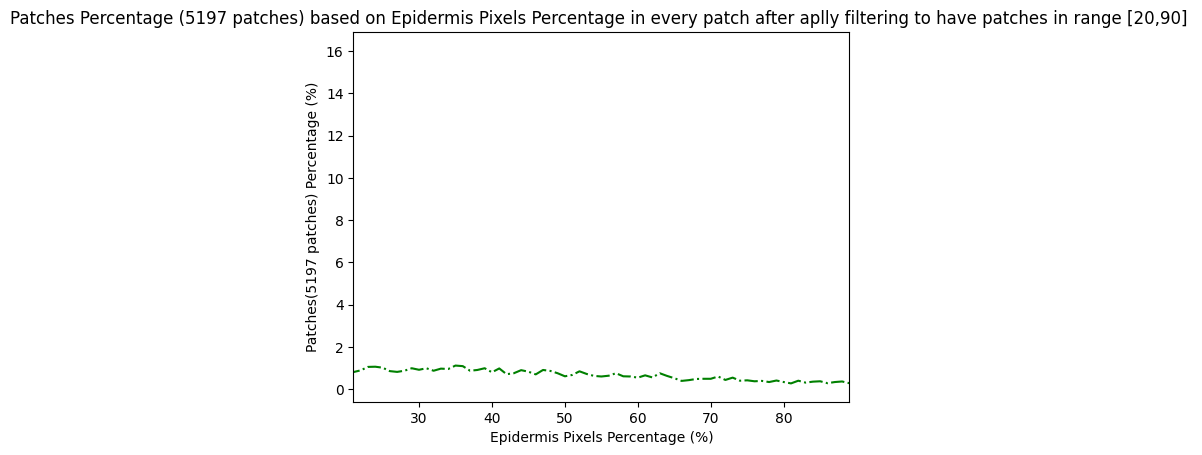

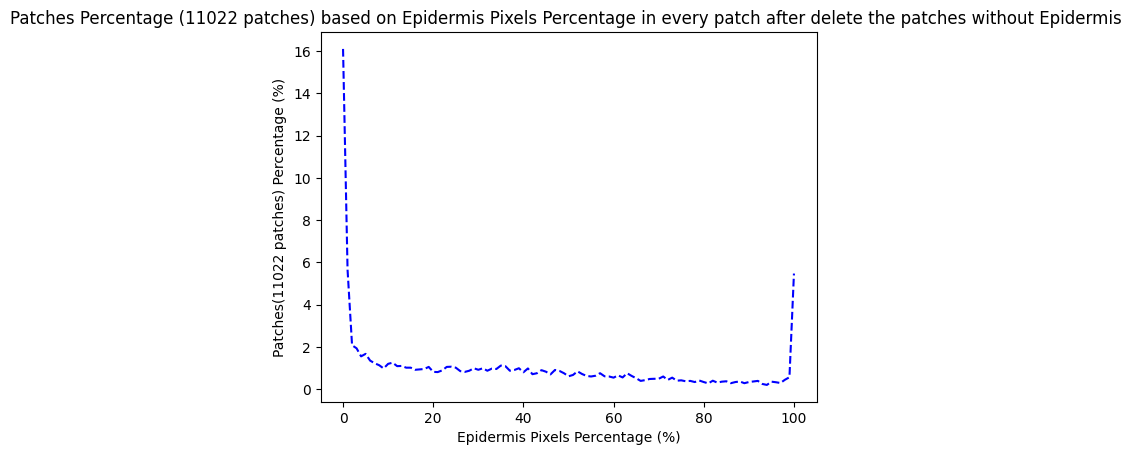

In [4]:
ax = plt.gca()
ax.set_xlabel("Epidermis Pixels Percentage (%)")
ax.set_ylabel('Patches('+str(len(df_filtered))+' patches) Percentage (%)')
df2.plot(kind = 'line', x = 'epidermis_percentage', y = 'slide_no', color = 'green',linestyle='-.',ax = ax)
plt.title('Patches Percentage ('+str(len(df_filtered))+' patches) based on Epidermis Pixels Percentage in every patch after aplly filtering to have patches in range [20,90] ')
ax.set_xlim(21, 89)
plt.show()
ax = plt.gca()
ax.set_xlabel("Epidermis Pixels Percentage (%)")
ax.set_ylabel('Patches('+str(len(df))+' patches) Percentage (%)')
df2.plot(kind = 'line', x = 'epidermis_percentage', y = 'slide_no', color = 'blue',linestyle='--',ax = ax)
plt.title('Patches Percentage ('+str(len(df))+' patches) based on Epidermis Pixels Percentage in every patch after delete the patches without Epidermis ')
plt.show()

In [5]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg16_unet(input_shape=(512, 512, 3)):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model



In [6]:
class DataGenerator(Sequence):
    def __init__(self, df, batch_size=8, image_size=(512, 512)):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __len__(self):
        return len(self.df) // self.batch_size

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size: (index + 1) * self.batch_size]

        images = []
        masks = []
        for _, row in batch_df.iterrows():
            image_path = row['img_fullpath']
            mask_path = row['mask_fullpath']
            image = self.load_image(image_path)
            mask = self.load_mask(mask_path)
            images.append(image)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)

    def load_image(self, image_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.image_size)
        image = image / 255.0
        return image

    def load_mask(self, mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.image_size)
        mask = np.expand_dims(mask, axis=-1)
        mask = mask / 255.0
        return mask



In [7]:

def dice_loss(y_true, y_pred):
    smooth = 1e-5
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice_coef = K.mean((2.0 * intersection + smooth) / (union + smooth), axis=0)
    return 1.0 - dice_coef


In [8]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [9]:
input_shape = (512, 512, 3)
model = build_vgg16_unet(input_shape)

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

# Create data generators for training and validation
train_generator = DataGenerator(train_df)
val_generator = DataGenerator(val_df)

epochs = 60
batch_size = 32

model.compile(optimizer='adam', loss=dice_loss, metrics=[mean_iou])
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, batch_size=batch_size)


Epoch 1/60
519/519 [==============================] - 147s 227ms/step - loss: 0.1970 - mean_iou: 0.6918 - val_loss: 0.9957 - val_mean_iou: 0.0020
Epoch 2/60
519/519 [==============================] - 116s 223ms/step - loss: 0.1808 - mean_iou: 0.7094 - val_loss: 0.1941 - val_mean_iou: 0.7095
Epoch 3/60
519/519 [==============================] - 114s 219ms/step - loss: 0.1746 - mean_iou: 0.7167 - val_loss: 0.4506 - val_mean_iou: 0.4627
Epoch 4/60
519/519 [==============================] - 115s 222ms/step - loss: 0.1678 - mean_iou: 0.7256 - val_loss: 0.9017 - val_mean_iou: 0.0740
Epoch 5/60
519/519 [==============================] - 116s 224ms/step - loss: 0.1640 - mean_iou: 0.7317 - val_loss: 0.2318 - val_mean_iou: 0.6374
Epoch 6/60
519/519 [==============================] - 117s 225ms/step - loss: 0.1632 - mean_iou: 0.7326 - val_loss: 0.2042 - val_mean_iou: 0.7070
Epoch 7/60
519/519 [==============================] - 114s 219ms/step - loss: 0.1594 - mean_iou: 0.7379 - val_loss: 0.1824 -

In [10]:
model.save('VGG_unet_filtered.h5');

In [18]:
model.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [11]:
history.history


{'loss': [0.19695810973644257,
  0.1807960867881775,
  0.1746470183134079,
  0.1678449958562851,
  0.163993239402771,
  0.16316662728786469,
  0.15941964089870453,
  0.1525377482175827,
  0.15575940907001495,
  0.1511078178882599,
  0.15054279565811157,
  0.1455371379852295,
  0.14183659851551056,
  0.14175772666931152,
  0.13666725158691406,
  0.13630224764347076,
  0.13306301832199097,
  0.1301891952753067,
  0.12666350603103638,
  0.12615351378917694,
  0.12412609159946442,
  0.12391111254692078,
  0.12075234949588776,
  0.11989292502403259,
  0.1159423291683197,
  0.11636140197515488,
  0.11446069180965424,
  0.11019150167703629,
  0.1108829602599144,
  0.11014709621667862,
  0.10801425576210022,
  0.10932917147874832,
  0.10433059930801392,
  0.10365830361843109,
  0.10613594204187393,
  0.10114900022745132,
  0.10127019882202148,
  0.09816765785217285,
  0.09966619312763214,
  0.10054273158311844,
  0.09794194996356964,
  0.09821770340204239,
  0.09382002055644989,
  0.0962835028

In [12]:
import json
with open("history_VGG_unet_filtered.json", "w") as outfile:
    json.dump(history.history, outfile)

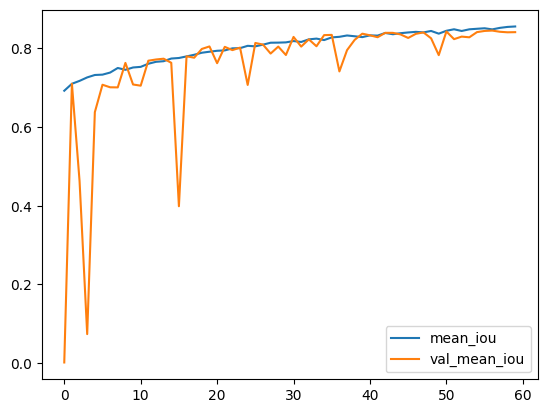

In [13]:
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.legend(['mean_iou', 'val_mean_iou'])
plt.show()

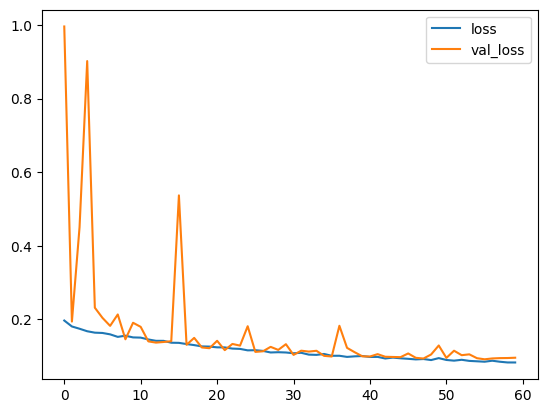

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [15]:
!cp /content/VGG_unet_filtered.h5 /content/drive/MyDrive/dataset_final/final_training_res/20230608_training_VGG-unet_filtered/VGG_unet_filtered.h5
!cp /content/history_VGG_unet_filtered.json /content/drive/MyDrive/dataset_final/final_training_res/20230608_training_VGG-unet_filtered/history_VGG_unet_filtered.json